Import the file

In [3]:
import json
with open('../data/bgg_RatingItem.jl', 'r') as source_file, open('../data/bgg_RatingItemCleaned.csv', 'w') as destination_file:

    destination_file.write('bgg_id'+';;'+'bgg_user_name'+';;'+'bgg_user_rating'+'\n')
    for line in source_file:
        #print(line)
        lineJson = json.loads(line)  # Load the JSON object to ensure it's valid
   
        # Write the line to the destination file
        if 'bgg_user_rating' in lineJson:
            destination_file.write(str(lineJson['bgg_id'])+';;'+str(lineJson['bgg_user_name'])+';;'+str(lineJson['bgg_user_rating'])+'\n')


Calculate how many reviews were without a rating

In [4]:
with open('../data/bgg_RatingItem.jl', 'r') as source_file, open('../data/bgg_RatingItemCleaned.csv', 'r') as cleaned_file:
    line_count = sum(1 for _ in source_file)
    line_count_cleaned = sum(1 for _ in cleaned_file)
print(f"The file contains {line_count} lines.")
print(f"The file contains {line_count_cleaned} lines.")

The file contains 63311160 lines.
The file contains 26221374 lines.


In [ ]:
import pandas as pd
df_game_item_from_scraper = pd.read_csv('../data/bgg_GameItem(1).csv') #Does not contain expansion but contain moved game
df_game_item_from_bgg = pd.read_csv('../data/boardgames_ranks.csv') #Does not contain moved game but contain expansion         #https://boardgamegeek.com/data_dumps/bg_ranks
# Filter rows where the 'id' column in df_game_item_from_scraper is not in df_game_item_from_bgg
filtered_rows = df_game_item_from_scraper[~df_game_item_from_scraper['bgg_id'].isin(df_game_item_from_bgg['id'])]

# Display the filtered rows
print(filtered_rows[['bgg_id', 'name']])


        bgg_id                                               name
1954      2279                                      PowerTechnics
5626      6457                                           Hegemony
5876      6736                                          Bonaparte
6280      7183               Weapons & Warriors: Lashout Launcher
9699     11082                                      Al Aflaj 1245
...        ...                                                ...
123782  433369  Villas’ Vengeance: The Raid on Columbus, New M...
123788  433385                                      Keksekästchen
123795  433396                                      Who the F*ck?
124311  436020                                               Atua
124455  436558                                      Star Explorer

[478 rows x 2 columns]


Draw an histogram of the ratings

In [11]:
import pandas as pd

# Read the cleaned file into a DataFrame
df_cleaned = pd.read_csv('../data/bgg_RatingItemCleaned.csv', sep=';;', engine='python')

In [12]:
df_cleaned = df_cleaned[~df_cleaned['bgg_id'].isin(filtered_rows['bgg_id'])]

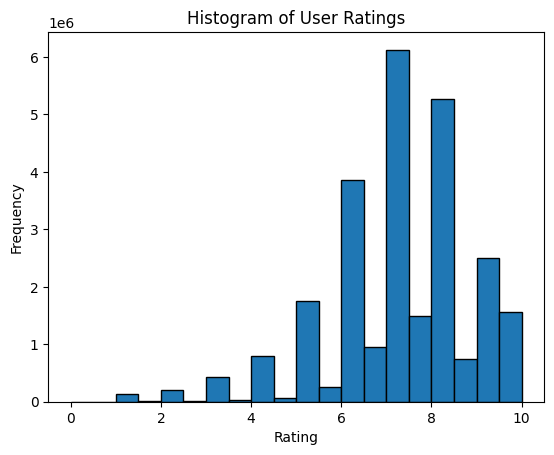

In [13]:
import pandas as pd

import matplotlib.pyplot as plt

# Convert the 'bgg_user_rating' column to numeric
df_cleaned['bgg_user_rating'] = pd.to_numeric(df_cleaned['bgg_user_rating'], errors='coerce')

# Plot the histogram
plt.hist(df_cleaned['bgg_user_rating'], bins=20, edgecolor='black')
plt.title('Histogram of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Distribution of Reviews per User')

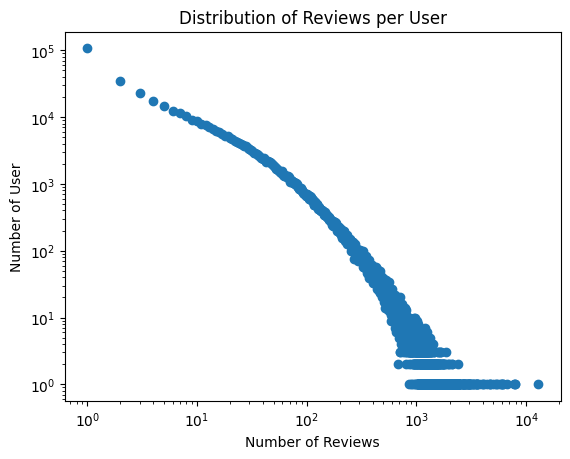

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Count how many reviews each user made
user_review_counts = df_cleaned['bgg_user_name'].value_counts()

# Count the number of users for each review count
review_distribution = user_review_counts.value_counts().sort_index()

# Plot the distribution

plt.loglog(review_distribution,'o')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of User')
plt.title('Distribution of Reviews per User')

Try to detect user that troll (extreme low ratings or high ratings)

In [15]:
# Define thresholds for extreme ratings
low_threshold = 1
high_threshold = 9

# Filter users with extreme ratings
extreme_raters = df_cleaned[(df_cleaned['bgg_user_rating'] <= low_threshold) | (df_cleaned['bgg_user_rating'] >= high_threshold)]

# Group by user and count their extreme ratings
extreme_raters_count = extreme_raters.groupby('bgg_user_name').size().reset_index(name='extreme_rating_count')

# Display users with extreme ratings
print(extreme_raters_count.sort_values(by='extreme_rating_count', ascending=False))

         bgg_user_name  extreme_rating_count
408586    thebardgamer                  5028
407424      the eraser                  2474
352354    roncarlson01                  2138
126502     eriksverker                  1367
346226   richardingram                  1337
...                ...                   ...
8                 -de-                     1
463097         zzonnii                     1
463099          zzpdxp                     1
33      007purpleroses                     1
34          00_fire_00                     1

[463145 rows x 2 columns]


Show distribution of ratings

Text(0.5, 1.0, 'Distribution of Reviews per Game')

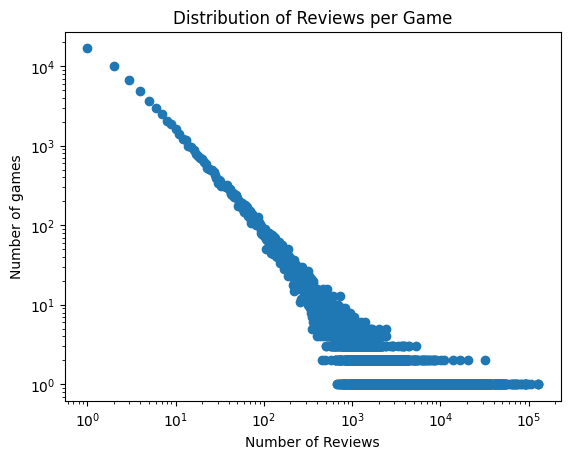

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Count the number of reviews for each game
game_review_counts = df_cleaned['bgg_id'].value_counts()

# Count how many games have a specific number of reviews
x = game_review_counts.value_counts().sort_index()

plt.loglog(x,'o')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of games')
plt.title('Distribution of Reviews per Game')

Remove game that have less than 100 Ratings

In [17]:
print("Number of games before filtering:", df_cleaned['bgg_id'].nunique(),"Number of reviews before filtering:", df_cleaned.shape[0])
# Count reviews per user
user_counts = df_cleaned['bgg_user_name'].value_counts()

# Get users with more than 1 review
users_to_keep = user_counts[user_counts > 1].index

# Remove reviews made by users with only one review
df_cleaned_filtered = df_cleaned[df_cleaned['bgg_user_name'].isin(users_to_keep)]

# Count the number of ratings per game
game_counts = df_cleaned_filtered['bgg_id'].value_counts()

# Select games with at least 100 ratings
games_to_keep = game_counts[game_counts >= 100].index

# Filter the DataFrame to keep only these games
df_cleaned_with_threshold = df_cleaned_filtered[df_cleaned_filtered['bgg_id'].isin(games_to_keep)]
print("Number of games after  filtering:", df_cleaned_with_threshold['bgg_id'].nunique()," Number of reviews after  filtering:", df_cleaned_with_threshold.shape[0])

Number of games before filtering: 95361 Number of reviews before filtering: 26212522
Number of games after  filtering: 15738  Number of reviews after  filtering: 24998740


Write to file

In [18]:
df_cleaned_with_threshold.to_csv('../data/bgg_rating_threshold.csv', header=True, index=False, sep=';')